In [88]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transform
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import time
import torch.nn.functional as F
import os

KeyboardInterrupt: 

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [90]:
image_size = 224
batch_size = 16
channel_size = 3
lr = 1e-3
num_epochs = 50
num_classes = 31

In [91]:
import torchvision.transforms as transforms
transformer = transforms.Compose([
    torchvision.models.MobileNet_V3_Small_Weights.IMAGENET1K_V1.transforms(),
])

In [1]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset

DATASET_DIR = '/home/crueang/jira/aiot project/office31'

amazon_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/amazon', transform=transformer)
dslr_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/dslr', transform=transformer)
webcam_dataset = datasets.ImageFolder(root=f'{DATASET_DIR}/webcam', transform=transformer)

classes = webcam_dataset.classes

Ds_amazon, Ds_amazon_test = random_split(amazon_dataset, [0.8, 0.2])
Ds_dslr, Ds_dslr_test = random_split(dslr_dataset, [0.8, 0.2])
Ds_webcam, Ds_webcam_test = random_split(amazon_dataset, [0.8, 0.2])

NameError: name 'transformer' is not defined

In [93]:
Dl_amazon = DataLoader(Ds_amazon, batch_size, shuffle=True, num_workers=2)
Dl_dslr = DataLoader(Ds_dslr, batch_size, shuffle=True, num_workers=2)
Dl_webcam = DataLoader(Ds_webcam, batch_size, shuffle=True, num_workers=2)

Dl_amazon_test = DataLoader(Ds_amazon_test, batch_size, shuffle=True, num_workers=2)
Dl_dslr_test = DataLoader(Ds_dslr_test, batch_size, shuffle=True, num_workers=2)
Dl_webcam_test = DataLoader(Ds_webcam_test, batch_size, shuffle=True, num_workers=2)

In [94]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


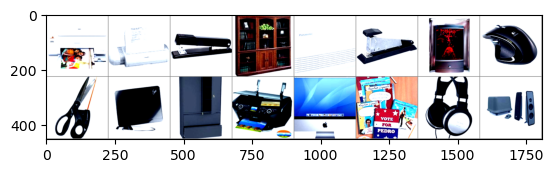

In [95]:
dataiter_src = iter(Dl_dslr)
img_src, lbl_src = next(dataiter_src)

img_src_grid = torchvision.utils.make_grid(img_src)
matplotlib_imshow(img_src_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


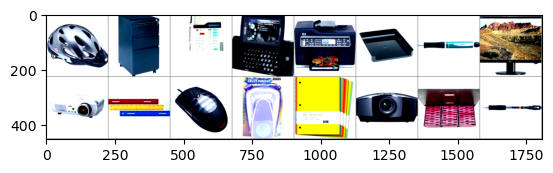

In [96]:
dataiter_src = iter(Dl_amazon)
img_src, lbl_src = next(dataiter_src)

img_src_grid = torchvision.utils.make_grid(img_src)
matplotlib_imshow(img_src_grid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


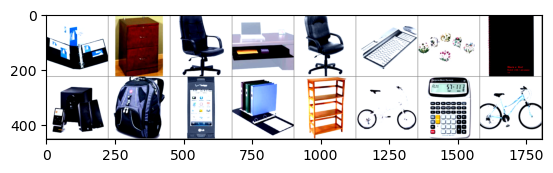

In [97]:
dataiter_src = iter(Dl_webcam)
img_src, lbl_src = next(dataiter_src)

img_src_grid = torchvision.utils.make_grid(img_src)
matplotlib_imshow(img_src_grid)

In [98]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_src_acc"], label="Train_src_acc")
    ax1.plot(history["train_tar_acc"], label="Train_tar_acc")
    ax1.legend()
    ax1.set_title("Accuracy (Src/Tar)")

    ax2.plot(history["train_loss"], label="Train_loss")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [99]:
class CorrelationAlignmentLoss(nn.Module):
    def __init__(self):
        super(CorrelationAlignmentLoss, self).__init__()

    def forward(self, f_s: torch.Tensor, f_t: torch.Tensor) -> torch.Tensor:
        mean_s = f_s.mean(0, keepdim=True)
        mean_t = f_t.mean(0, keepdim=True)
        cent_s = f_s - mean_s
        cent_t = f_t - mean_t
        cov_s = torch.mm(cent_s.t(), cent_s) / (len(f_s) - 1)
        cov_t = torch.mm(cent_t.t(), cent_t) / (len(f_t) - 1)

        mean_diff = (mean_s - mean_t).pow(2).mean()
        cov_diff = (cov_s - cov_t).pow(2).mean()

        return mean_diff + cov_diff

In [100]:
teacher = torchvision.models.mobilenet_v3_large(n_C=num_classes, weights=True).to(device)

In [101]:
lambda_coral = 1.0

# loss_fn_class = torch.nn.NLLLoss()
# loss_fn_domain = torch.nn.NLLLoss()
loss_fn_class = torch.nn.CrossEntropyLoss()

# Training the same number of batches from both datasets

# network

model = torchvision.models.mobilenet_v3_small(n_C=num_classes, weights=True).to(device)
summary(model, input_size=(channel_size, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [102]:
DATASET_DIR = '/home/crueang/Chaks/AIOT_project/data/Office-31'
HOME = '/home/crueang/Chaks/AIOT_project'

In [103]:
# Training
def train(model, optimizer, Dl_source, Dl_target, Dl_test):
    max_batches = min(len(Dl_source), len(Dl_target))
    t_0 = time.time()
    training_logs_coral = {"train_loss": [],  "train_src_acc": [], "train_tar_acc": [], "test_acc": []}
    for epoch_idx in range(num_epochs):
        train_loss, train_src_correct, train_tar_correct, test_correct = 0, 0, 0, 0
        
        print(f'epochs {epoch_idx+1:04d} / {num_epochs:04d}', end='\n============\n')
        Dl_source_iter = iter(Dl_source)
        Dl_target_iter = iter(Dl_target)
        Dl_test_iter = iter(Dl_test)

        for batch_idx in range(max_batches):
        # Actually: (rely on number of data in Dataloader), for i, data in enumerate(trainloader, 0):
            optimizer.zero_grad()

            # Training on source domain
            X_s, y_s = next(Dl_source_iter)

            # Training on target domain
            X_t, y_t = next(Dl_target_iter)
            
            if (Dl_test_iter._num_yielded <= batch_idx):
                Dl_test_iter._reset(Dl_test)
            X_test, y_test = next(Dl_test_iter)

            if X_s.shape[0] != X_t.shape[0]:
                min_bs = min(X_s.shape[0], X_t.shape[0])
                X_s = X_s[:min_bs]
                y_s = y_s[:min_bs]
                X_t = X_t[:min_bs]
                y_t = y_t[:min_bs]


            # GPU processing source and target data
            X_s, y_s = X_s.to(device), y_s.to(device)
            X_t, y_t = X_t.to(device), y_t.to(device)
            X_test, y_test = X_test.to(device), y_test.to(device)

            class_pred_s = model(X_s)
            class_pred_t = model(X_t)
            
            loss_src = loss_fn_class(class_pred_s, y_s)                 # source classification loss

            ################### Regularizer ########################
            # Correlation alignment loss
            loss_coral = CorrelationAlignmentLoss()(class_pred_s, class_pred_t)
            ########################################################

            # back-propagation (reversed grad to maximize domain loss)
            loss = loss_src + lambda_coral * loss_coral
            loss.backward()
            # optimization tuning
            optimizer.step()

            # #output predict from net
            with torch.no_grad():
                class_prediction_s = model(X_s)
                class_prediction_t = model(X_t)
                class_prediction_test = model(X_test)

            train_loss += loss.item()
            train_src_correct += (class_prediction_s.argmax(1) == y_s).float().sum().item()
            train_tar_correct += (class_prediction_t.argmax(1) == y_t).float().sum().item()
            test_correct += (class_prediction_test.argmax(1) == y_test).float().sum().item()

        training_logs_coral["train_loss"].append(train_loss / len(Dl_source))
        training_logs_coral["train_src_acc"].append(train_src_correct / len(Dl_source.dataset))#.dataset))
        training_logs_coral["train_tar_acc"].append(train_tar_correct / len(Dl_target.dataset))#.dataset))
        training_logs_coral["test_acc"].append(test_correct / (batch_size*max_batches))
        
        if training_logs_coral["test_acc"][-1] == max(training_logs_coral["test_acc"]):
            torch.save(model.state_dict(), f'{path_save_cp}best_model.pth')

        print(f'Epoch: {epoch_idx+1} || \
        Train_src_acc: {train_src_correct / len(Dl_source.dataset)}, \
        Train_tar_acc: {train_tar_correct / len(Dl_target.dataset)}, \
        Test_acc: {test_correct / (batch_size*max_batches)}, \
        Train_loss: {train_loss / len(Dl_source)}'
        )

    t_end = time.time()-t_0
    print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end} sec")

    plot_graph(training_logs_coral)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 112, 112]             216
       BatchNorm2d-2          [-1, 8, 112, 112]              16
         Hardswish-3          [-1, 8, 112, 112]               0
            Conv2d-4            [-1, 8, 56, 56]              72
       BatchNorm2d-5            [-1, 8, 56, 56]              16
              ReLU-6            [-1, 8, 56, 56]               0
 AdaptiveAvgPool2d-7              [-1, 8, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]              72
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]              72
      Hardsigmoid-11              [-1, 8, 1, 1]               0
SqueezeExcitation-12            [-1, 8, 56, 56]               0
           Conv2d-13            [-1, 8, 56, 56]              64
      BatchNorm2d-14            [-1, 8,

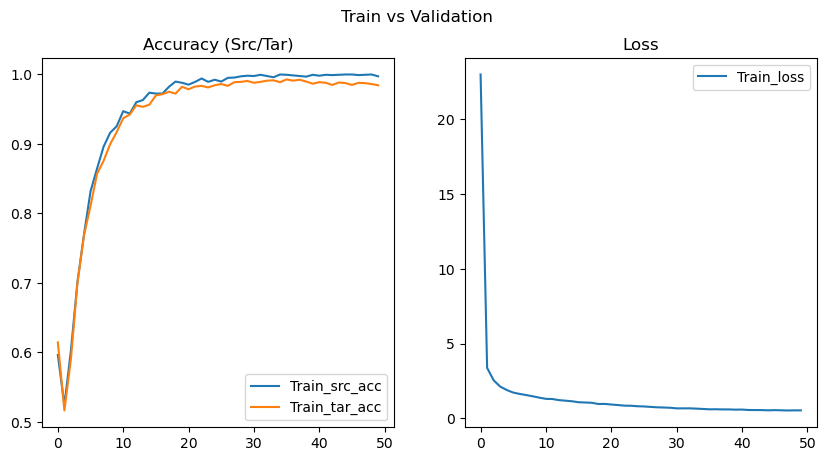

In [104]:
model = torchvision.models.mobilenet_v3_small(weights=None, width_mult=0.25, num_classes=31).to(device)
model.load_state_dict(torch.load(f'{HOME}/cp/mbv3_small_reduce/best_model.pth', weights_only=True))
summary(model, (3, 224, 224))
optimizer = optim.Adam(model.parameters(), lr)

train(model, optimizer, Dl_amazon, Dl_dslr, Dl_dslr_test)

path_save_cp = '/home/crueang/Chaks/AIOT_project/cp/mbv3_red_coral_A2D/'
if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)

torch.save(model.state_dict(), path_save_cp+'coral_A-D.pth')

In [ ]:
p